In [11]:
from itertools import combinations
import numpy as np
from dataclasses import dataclass
from icecream import ic
import matplotlib.pyplot as plt

## Simple Test Problem

In [12]:
CITIES = [
    "Rome",
    "Milan",
    "Naples",
    "Turin",
    "Palermo",
    "Genoa",
    "Bologna",
    "Florence",
    "Bari",
    "Catania",
    "Venice",
    "Verona",
    "Messina",
    "Padua",
    "Trieste",
    "Taranto",
    "Brescia",
    "Prato",
    "Parma",
    "Modena",
]
test_problem = np.load('lab2/test_problem.npy')

## Common tests

In [13]:
problem = np.load('lab2/problem_r1_10.npy')

In [14]:
# Negative values?
np.any(problem < 0)

np.False_

In [15]:
# Diagonal is all zero?
np.allclose(np.diag(problem), 0.0)

True

In [16]:
# Symmetric matrix?
np.allclose(problem, problem.T)

False

In [17]:
# Triangular inequality
all(
    problem[x, y] <= problem[x, z] + problem[z, y]
    for x, y, z in list(combinations(range(problem.shape[0]), 3))
)

False

## Evolutionary Algorithm

In [18]:
@dataclass
class Population:
    genotypes: np.ndarray 
    fitness: np.ndarray    

- fitness function

In [19]:
def fitness(sol: np.ndarray, problem: np.ndarray) -> np.float64:
    u = sol
    v = np.roll(sol, -1)
    total = problem[u, v].sum(dtype=np.float64)
    return np.float64(total)

def fitness_batch(pop: np.ndarray, problem: np.ndarray) -> np.ndarray:
    u = pop
    v = np.roll(pop, -1, axis=1)
    return problem[u, v].sum(axis=1, dtype=np.float64)

- mutation functions

In [20]:
# tested all these mutation with an ILS to see which is the best for each kind of problem:
# for g problems the best is inversion
# for r1 and r2 problems the best is three_opt

def inversion(parent: np.ndarray, rng: np.random.Generator | None = None) -> np.ndarray:
    # see slides 05 Searching for a State - EA, page 51

    rng = rng or np.random.default_rng()
    i, j = sorted(rng.choice(parent.size, size=2, replace=False))
    child = parent.copy()
    child[i:j] = child[i:j][::-1]
    return child

def insertion(parent: np.ndarray, rng: np.random.Generator | None = None) -> np.ndarray:
    # see slides 05 Searching for a State - EA, page 50

    n = parent.size
    rng = rng or np.random.default_rng()
    i, j = rng.choice(n, size=2, replace=False)
    child = parent.tolist()
    gene = child.pop(i)
    child.insert(j, gene)
    return np.asarray(child, dtype=parent.dtype)

def swap(parent: np.ndarray, rng: np.random.Generator | None = None) -> np.ndarray:
    # see slides 05 Searching for a State - EA, page 49

    rng = rng or np.random.default_rng()
    n = parent.size
    i, j = rng.choice(n, size=2, replace=False)
    child = parent.copy()
    child[i], child[j] = child[j], child[i]
    return child

def shuffle(p: np.ndarray, rng: np.random.Generator | None = None) -> np.ndarray:
    # see slides 05 Searching for a State - EA, page 50
     
    n = p.size
    rng = rng or np.random.default_rng()
    i, j = sorted(rng.choice(n, size=2, replace=False))
    if j - i < 2:
        j = min(n, i + 2)
        i = max(0, j - 2)
    c = p.copy()
    c[i:j] = rng.permutation(c[i:j])
    return c


def three_opt(tour, rng):
    # inspired by https://en.wikipedia.org/wiki/3-opt the only difference in this version is randomness

    n = len(tour)
    i, j, k = sorted(rng.choice(n, size=3, replace=False))
    new_tour = np.concatenate([tour[:i], tour[j:k], tour[i:j], tour[k:]])
    return new_tour


- test muation functions
- test problem g, r1, r2 all size 100

In [21]:
def ILS(problem: np.ndarray, mutation) -> tuple[np.ndarray, float, list[float]]:

    rng = np.random.default_rng()
    MAX_ITERS = 10000

    n = problem.shape[0]
    cur = rng.permutation(n).astype(np.int32)          
    cur_cost = float(fitness(cur, problem))            
    hc_history = [cur_cost]

    for i in range(MAX_ITERS):
        cand = mutation(cur, rng=rng).astype(np.int32, copy=False)
        cand_cost = float(fitness(cand, problem))

        if cand_cost < cur_cost:                     
            cur, cur_cost = cand, cand_cost

        hc_history.append(cur_cost)

    best_route = cur
    best_cost = cur_cost
    return (best_route, best_cost, hc_history)

mutation = [inversion, insertion, swap, shuffle, three_opt]

- tests for g

ic| best_cost: 4610.421385781478
    best_route: array([28, 60, 11,  2, 58, 70, 56, 18, 53, 16, 68, 81, 69, 22, 37,  0, 14,
                       33, 54, 67, 32, 48, 64, 30, 97, 42, 10, 31, 72, 57, 41, 74, 71, 47,
                       63, 27, 20, 99,  7,  5, 49,  1,  8,  4, 36, 46, 93, 75, 55, 86, 34,
                       87, 43, 92, 88, 78, 12, 91,  6, 50, 15, 77, 85, 89, 83, 52, 25, 80,
                       19, 40, 24, 26, 13, 98, 39, 65, 59, 82,  9, 23, 61, 62, 29, 96, 76,
                       90, 38, 95, 35, 17, 44, 94, 79, 66, 45, 73, 84,  3, 51, 21],
                      dtype=int32)


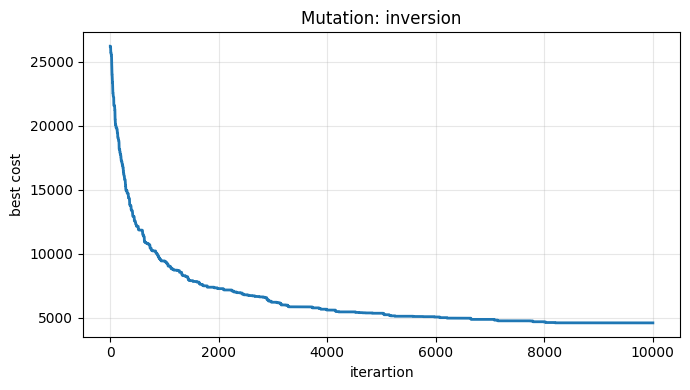

ic| best_cost: 6319.355799345873
    best_route: array([58, 70, 18, 56, 53, 16, 26, 77,  6, 12, 92, 78, 88, 55, 36, 46, 93,
                       99, 71, 47, 63, 27, 74,  0, 20, 41, 57, 66, 79, 17, 44, 73, 84,  3,
                       51, 28, 21, 60, 72, 31, 67, 37,  5,  8, 34, 43, 87, 86, 75,  4,  1,
                       89, 50, 15, 91, 85, 49,  7, 22, 69, 83, 13, 76, 23, 59, 65, 96, 25,
                       81, 42, 32, 54, 33, 14, 48, 10, 64, 97, 30, 68, 52, 62, 29, 95, 61,
                        9, 82, 39, 98, 80, 19, 24, 40, 90, 38, 35, 94, 45, 11,  2],
                      dtype=int32)


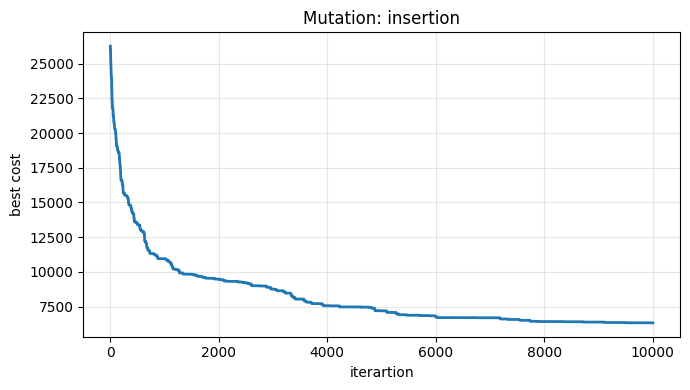

ic| best_cost: 7326.72103330701
    best_route: array([65, 29, 90, 52, 83, 89,  1, 69,  8, 43, 87, 86, 34, 75, 36, 49,  5,
                        7, 99, 27, 20, 33, 22,  6, 92, 88, 78, 91, 40, 24, 19, 80, 98,  9,
                       82, 59, 96, 13, 25, 77, 37, 67, 54, 32, 31, 53, 45, 73, 56, 72, 48,
                       10, 64, 42, 18, 60, 21, 84, 66, 44, 79, 17, 35, 38, 26, 85,  4, 46,
                       93, 55, 12, 15, 50, 62, 23, 61, 95,  3, 51, 28, 70, 30, 81, 68, 11,
                        2, 58, 57, 41, 14,  0, 63, 47, 71, 74, 97, 16, 94, 76, 39],
                      dtype=int32)


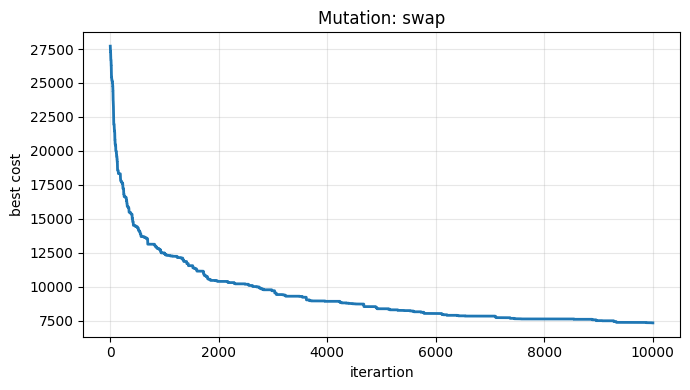

ic| best_cost: 14028.173474494184
    best_route: array([40, 96, 76, 59, 29, 42, 52, 12, 34, 49, 48, 41, 57, 60,  3, 53, 44,
                       16, 89, 75,  6, 77, 15, 50, 61, 81, 22, 71, 99,  4, 24, 19, 98,  9,
                       92, 43, 86, 20, 74,  7,  8, 70, 68, 32, 67, 54, 66, 11, 45, 94, 35,
                       90, 39, 26, 30, 72, 64, 31,  0, 28, 17, 23, 25, 87, 46, 55,  1, 18,
                       58,  2, 21, 37, 83, 38, 62, 65, 13, 88, 93, 63, 47,  5, 10, 56, 97,
                       69, 91, 78, 80, 82, 95, 79, 51, 73, 36, 27, 14, 33, 84, 85],
                      dtype=int32)


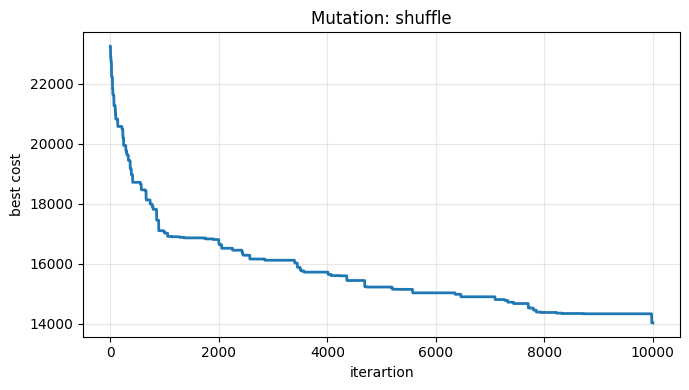

ic| best_cost: 6616.98926175364
    best_route: array([16, 94, 79, 66, 84,  2, 11, 58, 73, 44, 45, 53, 17, 97, 68, 81, 30,
                       22,  1, 64, 52, 83, 50, 24, 40, 77, 12, 15, 91,  6, 34,  4, 86, 88,
                       92, 78, 87, 43, 55, 75, 93,  7, 20, 27, 63, 71, 47, 99,  5, 49,  8,
                       46, 36, 10, 42, 32, 67, 33, 48, 31, 72, 57, 70, 18, 56, 28, 21, 51,
                        3, 60, 14, 41, 74,  0, 54, 37, 69, 85, 89, 26, 25, 19, 96, 39, 98,
                       13, 76, 65,  9, 82, 80, 29, 90, 35, 95, 59, 61, 23, 62, 38],
                      dtype=int32)


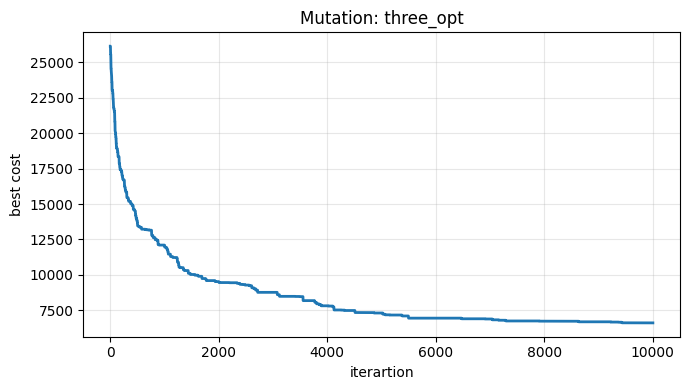

In [22]:
problem = np.load('lab2/problem_g_100.npy')
for mut in mutation:
    best_route, best_cost, best_history = ILS(problem, mut)
    ic(best_cost, best_route)
    x = np.arange(1, len(best_history) + 1)
    plt.figure(figsize=(7, 4))
    plt.plot(x, best_history, color='tab:blue', lw=2)
    plt.xlabel('iterartion')
    plt.ylabel('best cost')
    plt.grid(True, alpha=0.3)
    plt.title(f"Mutation: {mut.__name__}")
    plt.tight_layout()
    plt.show()

- tests for r1

ic| best_cost: 2107.406511828269
    best_route: array([60, 79, 44,  4, 75, 66, 92, 76, 39, 58, 26, 37, 96, 51, 94, 24, 23,
                       71, 16, 91, 32, 80, 49, 28, 50, 27, 54, 56, 55, 69, 29, 99,  8, 14,
                       10, 15, 88, 59, 57, 53,  5, 43, 13, 45, 48, 22, 36, 38, 31, 61, 72,
                        6, 30, 46, 20, 90, 19, 77, 93, 95, 74,  1, 89, 21, 34, 64, 18,  0,
                       63, 42, 97,  7, 67,  3, 98, 12, 17, 41, 70, 25, 81, 35, 52, 86, 62,
                       68, 78, 84, 47, 87, 83, 65, 40, 11,  2, 73, 85, 82,  9, 33],
                      dtype=int32)


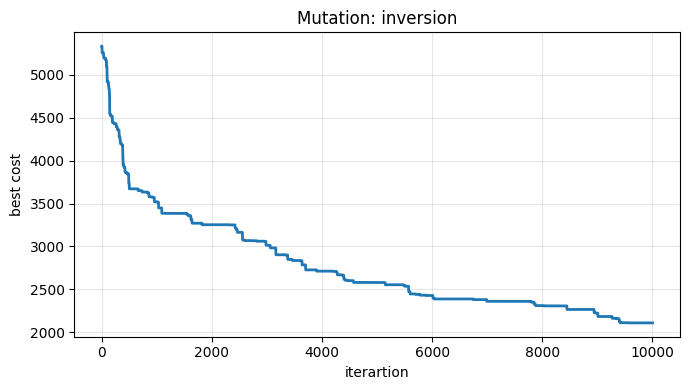

ic| best_cost: 1359.0425864476676
    best_route: array([72, 32,  5, 51, 38, 70, 84, 65, 55, 87, 94, 98, 16, 36, 58, 12,  4,
                       85, 31,  9, 10, 26, 69, 95, 29, 35,  8, 81, 25, 43, 17, 41, 75, 13,
                       71, 62, 28, 68, 57, 19, 23, 20, 77, 93, 74, 78, 47, 45, 37, 60, 14,
                       50, 99, 73,  7, 21, 34, 44, 89, 97, 27, 54, 33, 63, 76, 92, 61,  0,
                        1, 83, 46, 86, 64, 79,  2, 11, 15, 88, 96, 52, 40, 56, 30, 18, 91,
                       42, 39, 66,  3,  6, 67, 59, 80, 22, 24, 48, 90, 53, 49, 82],
                      dtype=int32)


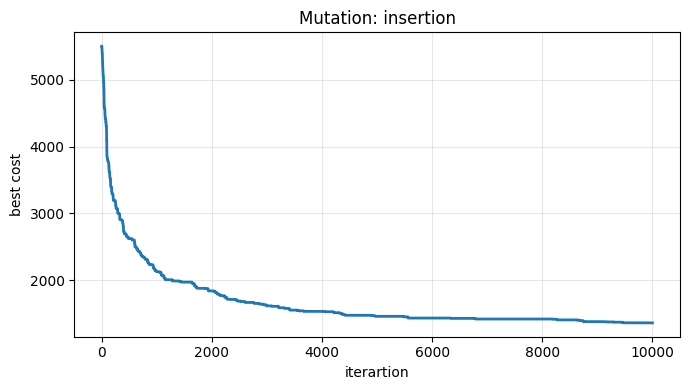

ic| best_cost: 1581.7713362047878
    best_route: array([84, 87, 46, 86, 40, 83, 25, 51, 38, 54, 16, 98, 49, 58, 94, 80, 24,
                       26, 69, 96, 62, 28, 68, 14, 64, 18,  1, 59, 63, 61, 47, 77, 65, 55,
                       93, 48, 90, 19, 10, 15, 81, 50, 11, 79,  2, 73, 45, 12,  4, 71, 72,
                        6, 67, 66,  0, 27, 34, 88, 89,  7, 44, 21, 37, 52, 99, 20, 85, 31,
                        3, 23, 22, 57, 53, 41, 35,  8, 29, 95, 74, 78, 32,  9, 92, 76, 39,
                       33, 82, 97, 30, 60, 56, 70, 42, 91, 75, 13, 36,  5, 43, 17],
                      dtype=int32)


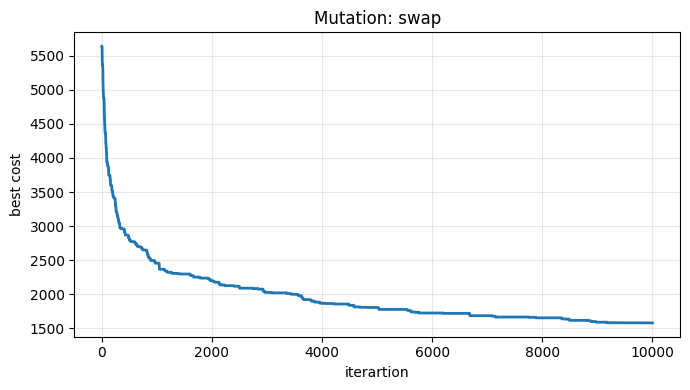

ic| best_cost: 2174.5833217078944
    best_route: array([33,  3, 97, 18, 30, 26, 55, 95, 69,  2, 27, 58, 43, 17, 47, 20, 65,
                       46, 77, 54, 38, 80, 98, 32, 31, 66, 39,  1, 89, 44,  0, 59,  9, 48,
                       99, 34, 96, 70, 83, 74,  8, 29, 62, 41, 45, 23,  6,  5, 85, 94, 22,
                       12, 24, 57, 53, 36, 51, 67, 92, 91, 72, 86, 87, 60, 14, 28, 11, 25,
                       63, 61, 76, 82, 93, 56, 50,  4, 13, 78, 37, 40, 64, 73, 35,  7, 21,
                       88, 10, 79, 52, 71, 90, 19, 84, 75, 42, 16, 49, 81, 15, 68],
                      dtype=int32)


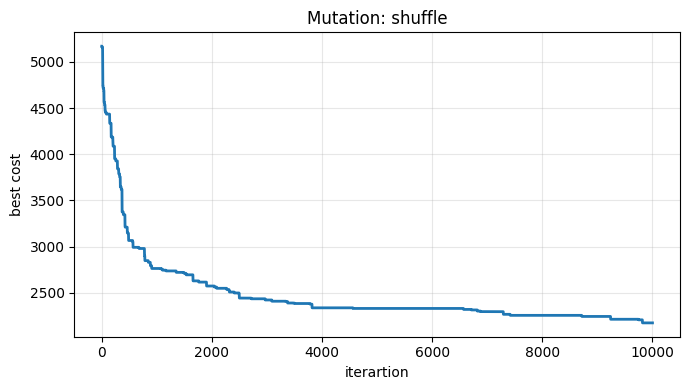

ic| best_cost: 1263.805566495304
    best_route: array([ 9, 33, 59, 63, 76, 61,  0,  1, 97, 32, 42, 91, 72, 31, 51,  5, 41,
                       43, 17, 78, 68, 79,  2, 50, 26, 95, 87, 74, 93, 83, 65, 20, 77, 46,
                       69, 55, 84, 48, 90, 23, 24, 58, 94, 80, 22, 36, 16, 66, 49, 38, 98,
                       82, 39,  6,  3, 54, 75, 85, 53, 12,  4, 13, 57, 45, 19, 47, 71, 70,
                       56, 25, 81, 99, 35,  8, 52, 40, 30, 60, 37, 18, 15, 88, 62, 34, 64,
                       10, 96, 73, 29, 11, 86, 14, 28, 44, 89, 21, 27,  7, 92, 67],
                      dtype=int32)


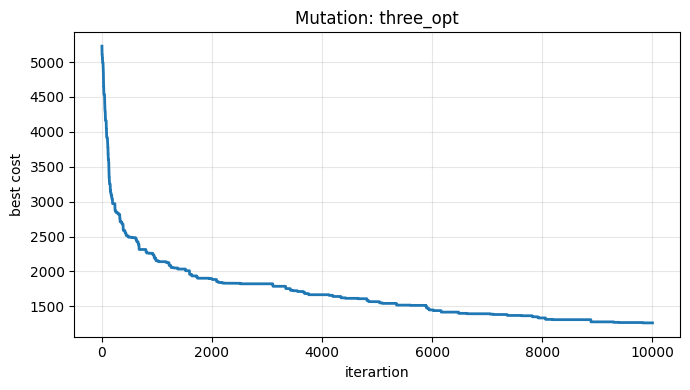

In [23]:
problem = np.load('lab2/problem_r1_100.npy')
for mut in mutation:
    best_route, best_cost, best_history = ILS(problem, mut)
    ic(best_cost, best_route)
    x = np.arange(1, len(best_history) + 1)
    plt.figure(figsize=(7, 4))
    plt.plot(x, best_history, color='tab:blue', lw=2)
    plt.xlabel('iterartion')
    plt.ylabel('best cost')
    plt.grid(True, alpha=0.3)
    plt.title(f"Mutation: {mut.__name__}")
    plt.tight_layout()
    plt.show()

- tests for r2

ic| best_cost: -2332.8535212183842
    best_route: array([76, 57, 44, 16, 83, 63, 62, 15, 40, 85, 47, 28, 60, 45, 24, 51, 12,
                       14, 82, 79, 92, 69, 39, 93, 81, 25, 31,  2, 70, 34, 73, 46, 78, 96,
                       21, 91, 87, 26, 61, 33, 65, 72,  8, 97, 35, 71, 49, 10, 58, 48,  1,
                       80, 42,  4, 68, 41, 89, 59, 22,  5, 55, 32, 86,  0, 66, 99, 90, 98,
                       29, 30,  6, 27, 52, 75, 84, 43, 23, 77, 74,  7, 67, 53, 64, 88, 56,
                       36, 38, 94, 11, 50, 54, 20, 19, 13, 17, 37,  9, 95, 18,  3],
                      dtype=int32)


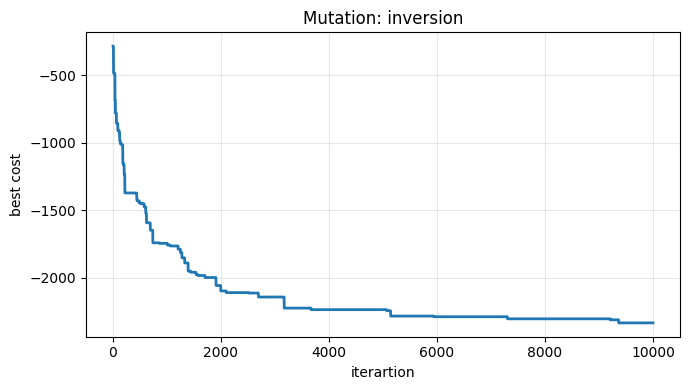

ic| best_cost: -4212.998333441647
    best_route: array([ 0,  6, 74, 66, 44, 56, 36, 52, 99, 21, 14, 62, 81, 58, 43, 34, 42,
                       86,  5, 38, 30, 53, 41, 95, 87, 15, 40, 37, 11, 50, 18, 98, 80,  9,
                       20, 19, 76, 73, 47, 27, 89, 90, 22, 54, 61, 70, 88, 64, 49, 83, 31,
                       35, 91,  4, 13, 82, 59, 10, 51, 48, 16, 79,  8, 97, 63,  3, 69, 46,
                       39, 94, 60, 68, 55, 32, 25, 33, 23,  2, 17, 26, 77, 24,  7, 72, 75,
                       71, 29,  1, 96, 12, 65, 78, 85, 84, 92, 57, 28, 45, 67, 93],
                      dtype=int32)


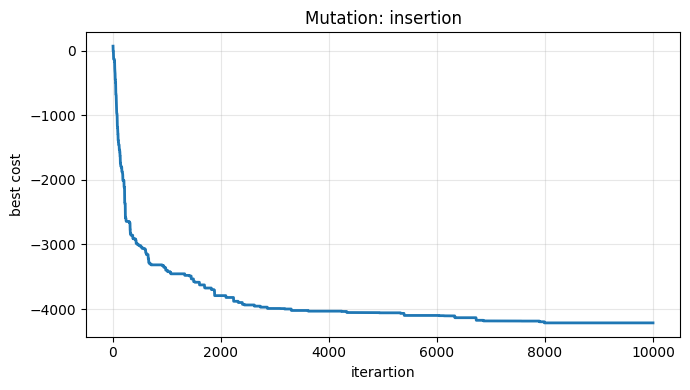

ic| best_cost: -3963.381605791269
    best_route: array([11, 62, 30, 65,  1,  0, 29, 73, 64, 72, 86, 21, 67, 58, 50, 25, 43,
                        3, 46, 15, 40, 60, 93, 53, 41, 32, 83, 59,  9, 33, 13, 20, 84, 61,
                       78, 22,  2,  8, 19, 35, 54, 70, 27, 97, 47, 77, 10, 76, 36, 26, 45,
                       68, 38, 94, 17, 37,  4, 74, 24, 81,  5, 85, 95, 34,  7, 89, 90, 28,
                        6, 57, 52, 49, 98, 66, 42, 91, 88, 44, 12, 96, 23, 16, 71, 51, 55,
                       18, 80, 39, 56, 14, 69, 99, 75, 48, 87, 79, 92, 63, 31, 82],
                      dtype=int32)


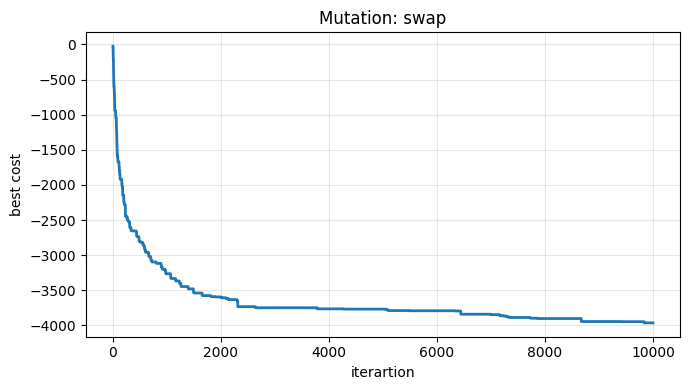

ic| best_cost: -3232.7855889096545
    best_route: array([60, 63, 23, 52, 42, 89, 47, 96, 21, 95,  2, 72,  4, 36,  6, 97, 43,
                       32, 39, 17, 54, 25, 22,  9, 65,  3, 29, 92, 41, 34, 83, 71, 86, 74,
                       48, 77, 50, 18, 84, 90, 37, 12, 10, 73, 38, 61,  8, 85, 57, 35, 58,
                       55, 70, 88, 44, 81,  5, 20, 28, 27, 87, 59, 69, 24, 91, 49, 99, 11,
                       15, 64, 62, 78, 80, 98, 53, 66, 68, 79, 93,  0, 45, 30, 75, 56,  1,
                       82, 19, 33, 40,  7, 46, 67, 76, 26, 13, 51, 31, 16, 94, 14],
                      dtype=int32)


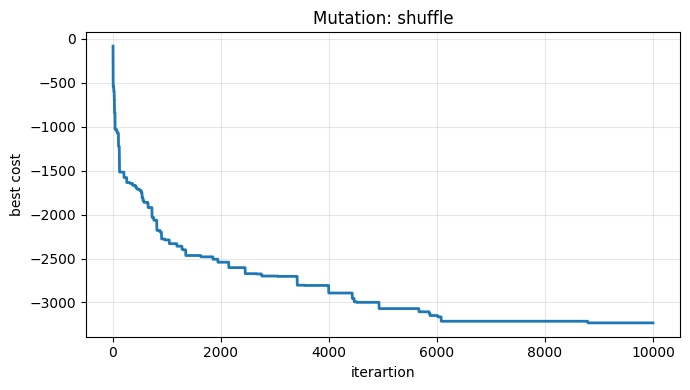

ic| best_cost: -4277.266748048775
    best_route: array([76, 99, 11, 29, 98, 66, 18, 80, 71, 82, 68, 63,  3, 52, 49, 83, 24,
                        2, 72, 86, 53, 44, 45, 67, 55, 12,  4, 77, 50, 31, 97, 16, 14, 36,
                       39, 17, 51, 79, 59, 22, 20,  5, 38, 30,  6, 84, 95,  7, 88, 73, 47,
                       81, 61, 40, 57, 75, 13, 92, 26, 87, 93, 37, 89, 94, 54, 41, 74, 48,
                       78, 10,  8, 85, 23, 90, 62, 70, 19, 32, 96, 69, 65, 15, 21, 28, 60,
                       46, 64, 34, 42, 25, 33, 56,  1,  0, 43, 58, 35, 91,  9, 27],
                      dtype=int32)


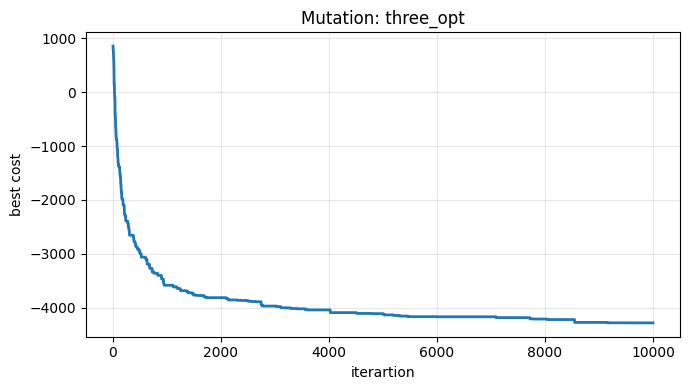

In [24]:
problem = np.load('lab2/problem_r2_100.npy')
for mut in mutation:
    best_route, best_cost, best_history = ILS(problem, mut)
    ic(best_cost, best_route)
    x = np.arange(1, len(best_history) + 1)
    plt.figure(figsize=(7, 4))
    plt.plot(x, best_history, color='tab:blue', lw=2)
    plt.xlabel('iterartion')
    plt.ylabel('best cost')
    plt.grid(True, alpha=0.3)
    plt.title(f"Mutation: {mut.__name__}")
    plt.tight_layout()
    plt.show()

- ricombination functions

In [ ]:
# tested empirically all the crossover non sitematically like i did with mutation, but the result seems the same
# the problem favor inversion like inver-over on symmetric tsp
# the other on asymmetric tsp

def pmx(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator | None = None) -> np.ndarray:
    # see slides 05 Searching for a State - EA, page 53

    n = p1.shape[0]
    rng = rng or np.random.default_rng()

    i, j = sorted(rng.choice(n, size=2, replace=False))

    c = np.full(n, -1, dtype=p1.dtype)

    c[i:j] = p1[i:j]

    seg1 = p1[i:j]
    seg2 = p2[i:j]
    set_seg1 = set(seg1.tolist())

    map12 = {a: b for a, b in zip(seg1, seg2)}

    for idx in list(range(0, i)) + list(range(j, n)):
        g = p2[idx]
        while g in set_seg1:
            g = map12[g]
        c[idx] = g

    return c

def cycle_crossover(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator | None = None) -> np.ndarray:

    # see slides 05 Searching for a State - EA, page 52
    
    rng = rng or np.random.default_rng()
    n = p1.shape[0]
    i, j = sorted(rng.choice(n, size=2, replace=False))


    c = np.full(n, -1, dtype=p1.dtype)
    c[i:j] = p1[i:j]


    used = np.zeros(n, dtype=bool)
    used[p1[i:j]] = True

    pos_out = np.r_[np.arange(0, i), np.arange(j, n)]
    fill = p2[~used[p2]][:pos_out.size]

    c[pos_out] = fill
    return c

# never used this crossover very inefficent   
#                                         |
#                                         V
def uniform_crossover(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator | None = None) -> np.ndarray:
    
    # Uniform crossover for permutation-encoded TSP.
    # - Position-wise mixing: for each index i, if parents agree and the allele is unused, copy it.
    # - Otherwise, pick between p1[i] and p2[i] with 50% probability, respecting a 'used' set to keep a valid permutation.
    # - If one candidate is already used, take the other; if both are used, insert a random unused allele.
    # - Produces a feasible permutation (no duplicates), runs in O(n). Uses rng for reproducibility.
    
    rng = rng or np.random.default_rng()
    n = p1.size
    c = np.full(n, -1, dtype=p1.dtype)
    used = np.zeros(n, dtype=bool)  

    for i in range(n):
        a, b = int(p1[i]), int(p2[i])

        if a == b and not used[a]:
            c[i] = a
            used[a] = True
            continue

        if used[a] and not used[b]:
            c[i] = b
            used[b] = True
            continue
        if used[b] and not used[a]:
            c[i] = a
            used[a] = True
            continue

        if not used[a] and not used[b]:
            pick = a if rng.random() < 0.5 else b
            c[i] = pick
            used[pick] = True
            continue

        remaining = np.flatnonzero(~used)
        val = int(remaining[rng.integers(remaining.size)])
        c[i] = val
        used[val] = True

    return c.astype(np.int32, copy=False)

def inver_over(parent1, parent2, rng):
    # see slides 05 Searching for a State - EA, page 53
    
    n = len(parent1)
    child = parent1.copy()
    i = rng.integers(n) 
    city_a = child[i]
    city_b = parent2[(np.where(parent2 == city_a)[0][0] + 1) % n]
    

    j = np.where(child == city_b)[0][0]
    
    if i < j:
        child[i+1:j+1] = child[i+1:j+1][::-1]
    else:
        child[j+1:i+1] = child[j+1:i+1][::-1]
    return child


- parent selection

In [26]:
def tournament(fitness: np.ndarray, k: int = 3, rng: np.random.Generator | None = None) -> int:
    rng = rng or np.random.default_rng()
    k = min(k, fitness.shape[0])
    idx = rng.choice(fitness.shape[0], size=k, replace=False)
    return idx[np.argmin(fitness[idx])]  


- genetic algorithm

In [27]:
# the solver is a genetic algorithm which implements a stady-state technique.
# the muatation function is decided for every run based on the result conducted on the muatation tests on the cell above
# the ricombination function is decided with the same principle of the mutation function although the results seems the same for all the problems
# in general i noted that for creating a new child it's better to preserve the order in asymmetric tsp rather then shuffling too much 
# that's beacuse the cost change a lot if you reverse a sub-tour

def tsp_solver(problem: np.ndarray, mutation, ricombination, parent_selection) -> tuple[np.ndarray, float, list[float]]:


    PROBLEM_SIZE = problem.shape[0]
    rng = np.random.default_rng()

    
    genotypes = np.vstack([rng.permutation(PROBLEM_SIZE) for _ in range(POPULATION_SIZE)]).astype(np.int32)
    fitnesses = fitness_batch(genotypes, problem)
    current_population = Population(genotypes=genotypes, fitness=fitnesses)

    best_fitness = float('inf')
    best_genotype = None
    best_history: list[float] = []
    
    for _gen in range(1, MAX_GENERATIONS + 1):
        
        offspring_genotypes = np.empty((OFFSPRING_SIZE, PROBLEM_SIZE), dtype=np.int32)
        
        for o in range(OFFSPRING_SIZE):
            if rng.random() < MUTATION_RATE:
                p = parent_selection(current_population.fitness, k=3, rng=rng)
                child = mutation(current_population.genotypes[p], rng=rng)
            else:
                p1 = parent_selection(current_population.fitness, k=3, rng=rng)
                p2 = parent_selection(current_population.fitness, k=3, rng=rng)
                while p2 == p1:
                    p2 = parent_selection(current_population.fitness, k=3, rng=rng)
                child = ricombination(current_population.genotypes[p1], current_population.genotypes[p2], rng=rng)
            offspring_genotypes[o, :] = child
        
    
        offspring_fitness = fitness_batch(offspring_genotypes, problem)

        all_genotypes = np.vstack([current_population.genotypes, offspring_genotypes])
        all_fitness = np.concatenate([current_population.fitness, offspring_fitness])
        order = np.argsort(all_fitness)
        current_population = Population(
            genotypes=all_genotypes[order][:POPULATION_SIZE],
            fitness=all_fitness[order][:POPULATION_SIZE],
        )

        if current_population.fitness[0] < best_fitness:
            best_fitness = current_population.fitness[0]
            best_genotype = current_population.genotypes[0]
        best_history.append(float(current_population.fitness[0]))

    return (best_genotype, best_fitness, best_history)


- lab2 problems

ic| best_fitness: np.float64(1497.6636482252911)
    best_genotype: array([1, 6, 4, 5, 9, 7, 0, 8, 2, 3], dtype=int32)


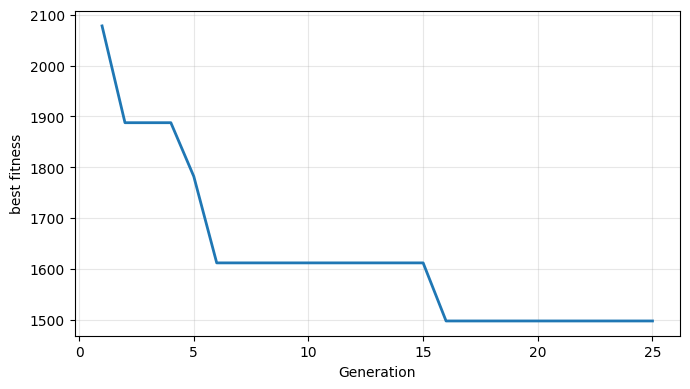

In [28]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 25

problem = np.load('lab2/problem_g_10.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, inversion, inver_over, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(1787.8784181894828)
    best_genotype: array([11, 13,  6,  8,  3, 15, 19, 14, 16,  9,  1,  7, 12,  2, 17,  4, 10,
                          18,  5,  0], dtype=int32)


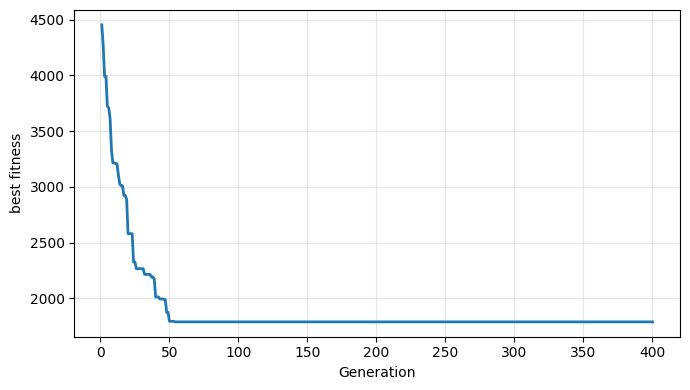

In [29]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 400

problem = np.load('lab2/problem_g_20.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, inversion, inver_over, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(2887.957234146431)
    best_genotype: array([42, 24, 19,  9, 31, 20, 46, 18, 17, 26, 39, 37, 21, 33, 41,  1, 36,
                          12, 49, 38,  8, 48, 40, 28, 15, 13, 35, 16, 45, 44,  6,  7, 23, 30,
                           5, 27,  0, 25, 14, 47, 43, 34, 10,  3, 11, 22,  4,  2, 29, 32],
                         dtype=int32)


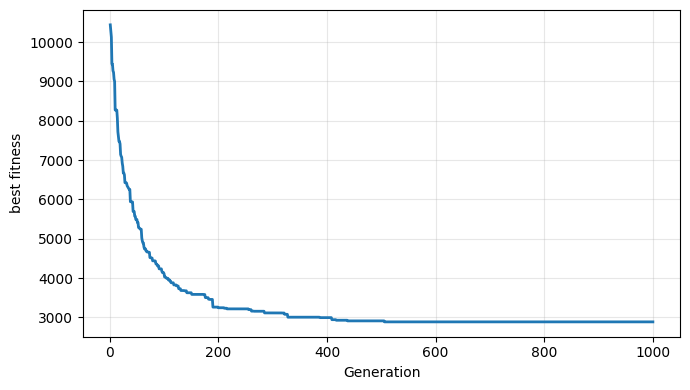

In [30]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 1000

problem = np.load('lab2/problem_g_50.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, inversion, pmx, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(4273.489057339476)
    best_genotype: array([ 3, 51, 28, 21, 60, 11,  2, 58, 57, 72, 31, 64, 97, 68, 81, 30, 42,
                          10, 48, 32, 67, 54, 33,  0, 14, 41, 74, 71, 47, 63, 99, 27, 20, 37,
                           7, 49,  5, 22,  1, 69,  8,  4, 36, 46, 93, 55, 75, 34, 86, 87, 43,
                          88, 78, 92, 12,  6, 77, 85, 89, 83, 52, 90, 13, 26, 25, 50, 15, 91,
                          24, 40, 19, 80, 96, 76, 98, 39, 65, 59, 82,  9, 23, 61, 29, 62, 95,
                          38, 35, 17, 44, 79, 94, 16, 56, 18, 70, 53, 73, 45, 66, 84],
                         dtype=int32)


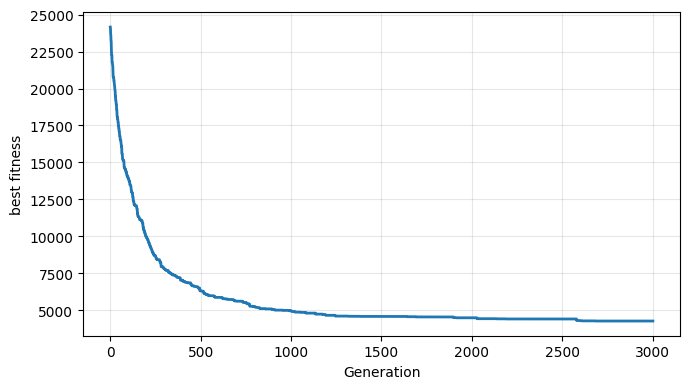

In [31]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 3000

problem = np.load('lab2/problem_g_100.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, inversion, inver_over, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(6452.654639883955)
    best_genotype: array([ 68,  31,  54, 103,   5, 147, 190,  69,  91,  29, 166, 145, 182,
                          141, 121,  89,  87,  25, 168, 187, 120,  72,  15, 105,  58, 161,
                          149,  70,  32,   4, 177,  95,  96, 135, 163,  14, 134, 179, 164,
                          192,  84, 108,  12, 152,  65, 114,  75, 127,  49, 162,  45,  94,
                           35,  55,  83,  16, 137, 180, 153, 159, 191, 195, 129,  61, 109,
                           11,  23, 198, 188,  79, 113,  36, 189,  44,  63,  90,  20,  28,
                           26, 174, 150,  43, 194,  30,  46,  38,   9,  98, 167, 186,  67,
                            6, 136, 139, 183,  60,   0,  37, 169,   8, 178,  24,  76, 124,
                           99, 138, 193, 172, 125,  64,  19,  33, 110, 122,  34,   3,  88,
                           81, 165,  27,   7, 142, 102, 170, 112, 128, 106,  66, 155,  53,
                           78, 111,   1, 1

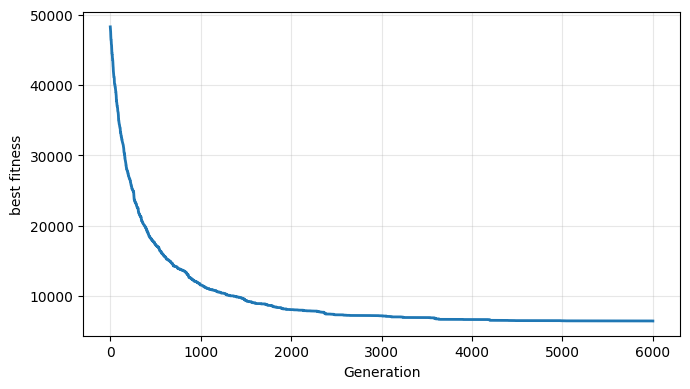

In [32]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 6000


problem = np.load('lab2/problem_g_200.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, inversion, inver_over, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(9512.868249170118)
    best_genotype: array([ 44,   2, 187,  24,  31, 214,  84, 347, 474, 432, 162, 226, 137,
                          439, 491, 112,  25, 433, 114, 219,  35, 283, 466, 447, 161, 443,
                          398, 117, 153, 480, 170, 239, 387, 256, 296,  60, 181,  47, 360,
                          262,  48,  59,  87,  36, 116,   3, 235,  21,  61,  95,  27, 307,
                          287, 120, 115, 435, 102, 301, 250,  49, 196,  46, 141, 492, 382,
                          366, 359, 429, 275, 462, 318, 324, 445, 206,  69, 470, 424, 304,
                          332, 320, 476,  63, 233, 160, 412, 415, 127, 104, 469, 385, 267,
                          129, 350, 285, 123, 477,  78, 222,  55, 374, 230, 351,  85, 383,
                          395, 472, 365,  53,  28,  38,  79,   4,  39, 377, 286, 194,  99,
                           64, 186,  43,  75,  70, 431, 111,  71, 105, 198, 195, 345, 270,
                          489, 334, 236, 2

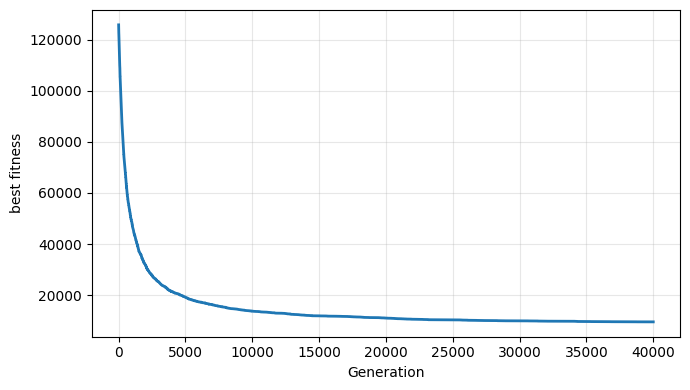

In [33]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 40000

problem = np.load('lab2/problem_g_500.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, inversion, inver_over, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(14274.757242881076)
    best_genotype: array([ 40, 751, 138, 369, 727, 424, 125, 996, 855, 399,  14, 548, 587,
                          342, 187, 180, 421,  99, 896, 150,   4, 802, 205, 212, 411, 487,
                          620, 478, 937, 603, 571, 882, 832, 594,  56, 962, 204, 106,   6,
                          650, 741, 414, 274, 708, 257, 821, 159, 614, 321,  20, 831,  64,
                          240, 234, 181, 679, 862, 508,  37, 329, 694, 308, 630, 216, 103,
                          730, 490, 979, 564, 661, 596, 367, 648, 574, 914, 169, 524, 877,
                          845, 393, 197, 446, 818,   2, 380, 865,  15, 520, 595, 302, 658,
                          835, 381, 550, 423, 534, 271, 191, 935, 481, 232, 327, 755, 681,
                          283,   8, 778, 488,  42, 983, 448,  84, 688, 690, 225, 428, 396,
                          586,  70, 964,   5, 592, 113, 435,  73, 300, 110, 840, 659, 142,
                          372, 451, 899, 

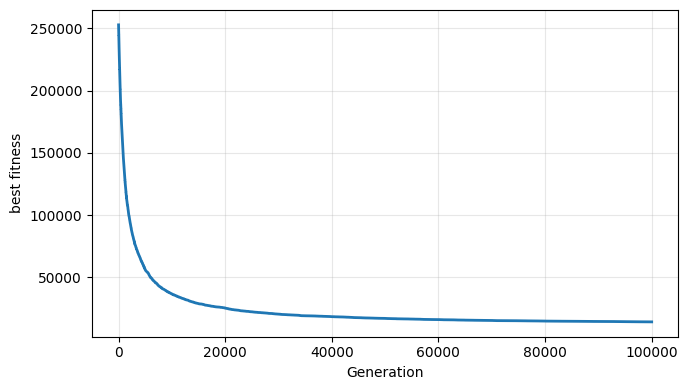

In [34]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 100000

problem = np.load('lab2/problem_g_1000.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, inversion, inver_over, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(196.61606461023166)
    best_genotype: array([6, 2, 1, 8, 0, 4, 9, 7, 5, 3], dtype=int32)


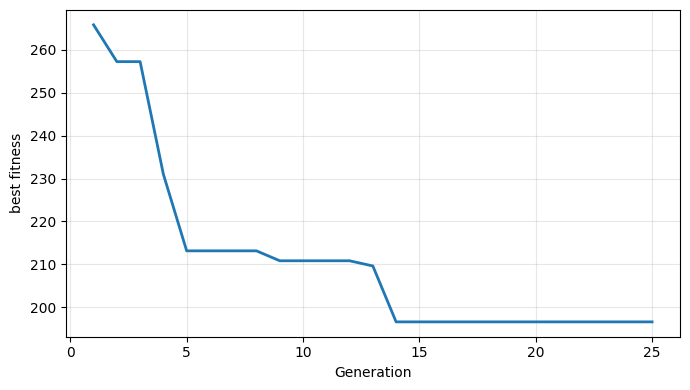

In [35]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 25

problem = np.load('lab2/problem_r1_10.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, cycle_crossover, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(364.7316599035788)
    best_genotype: array([ 5, 11, 18, 14,  2, 19,  0,  3,  1,  4, 16, 12,  9,  6, 15, 17,  7,
                          13,  8, 10], dtype=int32)


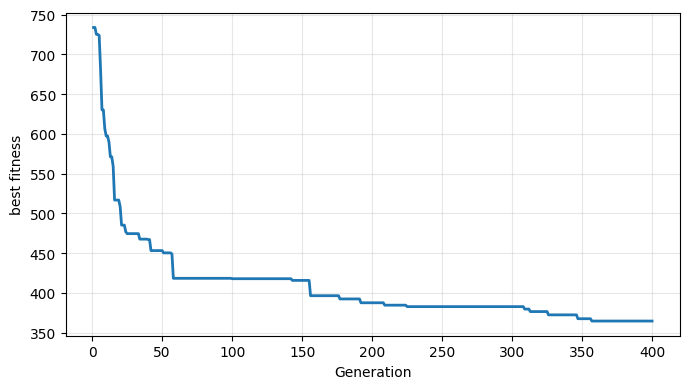

In [36]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 400

problem = np.load('lab2/problem_r1_20.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, cycle_crossover, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(563.575151938684)
    best_genotype: array([35, 38, 41, 48, 18, 30,  6,  9, 45, 20, 17, 12, 16, 15, 42, 13, 29,
                           5,  1,  8, 26, 21, 27,  0,  3,  7, 49, 46, 34, 23, 14,  2, 24, 37,
                          10, 33, 11, 44, 39, 36, 22, 31, 32, 43, 25,  4, 19, 47, 28, 40],
                         dtype=int32)


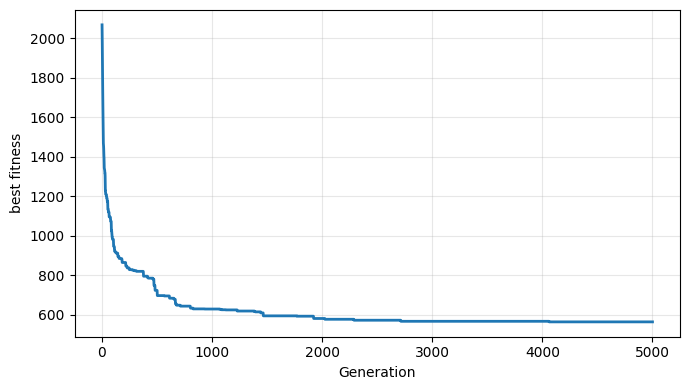

In [37]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 5000

problem = np.load('lab2/problem_r1_50.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, cycle_crossover, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(779.4887701077369)
    best_genotype: array([30, 37, 60, 40, 35, 99,  8, 52, 29, 81, 50,  2, 68, 10, 15, 79, 11,
                          73, 69, 26, 46, 86, 64, 14, 96, 28, 62, 88, 34, 21, 27,  7, 44, 89,
                          18, 91, 82, 97, 42,  0,  1, 92, 76, 59,  9, 31, 72,  6, 67, 39,  3,
                          66, 61, 63, 33, 32, 16, 98, 54, 38, 49, 75, 13, 71, 85,  4, 53, 58,
                          36, 51,  5, 94, 80, 22, 57, 19, 23, 47, 87, 20, 74, 95, 93, 77, 83,
                          65, 55, 84, 17, 45, 90, 48, 24, 12, 43, 41, 78, 70, 25, 56],
                         dtype=int32)


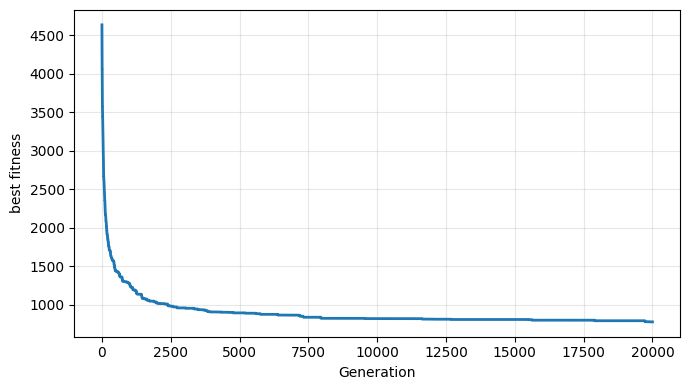

In [38]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 20000

problem = np.load('lab2/problem_r1_100.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, cycle_crossover, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(1228.2821160172919)
    best_genotype: array([112,  87,  31,  98,  27,  81,  91,  11, 171,  18, 164,  80,   0,
                          159, 178,  60, 191, 150, 138, 173, 123, 125, 135, 147,  56, 136,
                          124,  53,  39, 122,   1, 155, 190, 186,  51,  49,  97,  30, 156,
                           25,  75, 183,  41,  12, 154, 195, 198,  67,  16,  74, 141,  79,
                          144, 130, 189,  50,  13,  99, 172, 121, 163,  21,  42,  43, 110,
                            9,  36, 177,  83,   2, 114, 109, 170,   7, 165, 188,  66, 199,
                            4,  73,   5, 103,  46,  77, 169, 179,  71,  65,  47,  55, 101,
                           78, 187, 162,  15,  90,  58, 131, 132, 120,  45, 105,  94,  29,
                          166, 193, 126,  57,  10,  64, 161,   6, 129, 143,  20, 153,  19,
                           95, 118,  48,  38, 151,  82,   8, 116,  93, 180, 119, 157,  28,
                          139, 160, 102, 

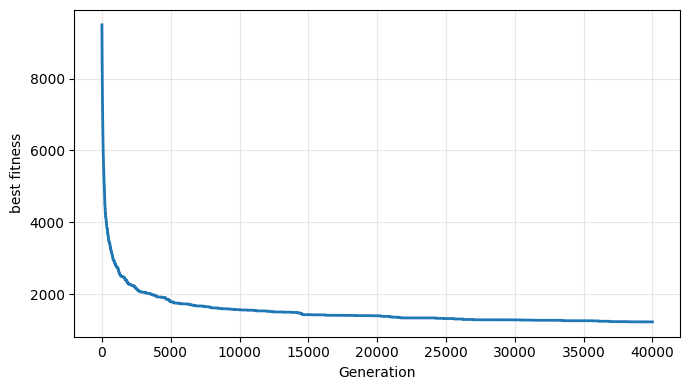

In [39]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 40000

problem = np.load('lab2/problem_r1_200.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, cycle_crossover, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(2751.382790576674)
    best_genotype: array([234,  57, 120, 288, 176,  99, 419, 484, 208, 209, 443,  89, 295,
                          171,  92, 353, 333, 213, 151, 115, 336, 493, 114, 238, 257, 258,
                          325, 425,  43, 449,  54, 205, 100, 436,  69, 217, 197,  90, 163,
                           44, 134, 354, 192,   2, 123, 121, 116, 469, 301,  85,  68, 190,
                          330, 366, 451,  23, 207, 434, 474, 363, 359, 452,  52, 382, 283,
                           66, 289, 403,   3, 178, 106, 432, 319, 435, 497, 405,  67, 131,
                          376, 290,  84, 350, 481, 175, 476, 351, 303, 332, 174,  60, 148,
                           21, 316,  47, 141, 210, 361, 326, 224, 464, 439, 111, 103, 223,
                          291, 416, 431, 226, 441, 252,  35, 337, 293, 125, 409,  74, 315,
                           65,  40, 306, 395, 371, 329,  76, 143, 206, 348, 465,  56, 362,
                          355, 276,  13, 1

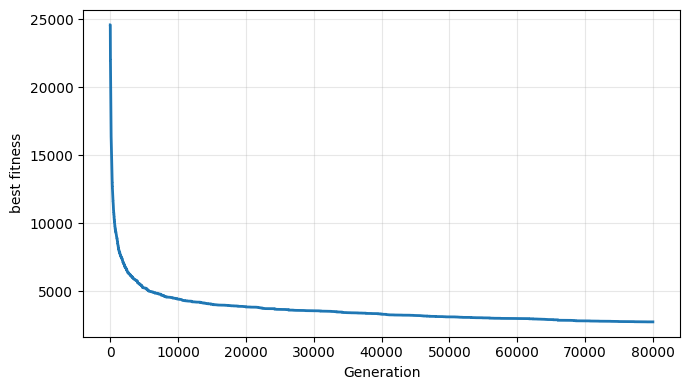

In [40]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 80000

problem = np.load('lab2/problem_r1_500.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, cycle_crossover, tournament)
ic(best_fitness, best_genotype)

x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(6091.718571733922)
    best_genotype: array([180,   1, 791, 772, 718,  66, 280, 274, 824, 256, 228, 139, 887,
                          358,  98, 194, 657, 784, 669, 201, 259, 477, 526, 578, 982,  90,
                          757, 555, 981, 323, 768, 188, 575, 811, 920,  61, 292, 419,  50,
                          434, 938, 787, 879, 269, 286, 596, 855, 251,  80, 211, 431, 146,
                          103, 108, 121, 614, 782, 359, 805, 631,  20, 624, 220, 532, 699,
                          968, 922, 670, 408, 890,   5, 564, 500, 582, 262,  25,  42,  56,
                          943, 357, 179, 119, 381, 706, 711, 291, 205, 388, 705,  37, 675,
                          651, 527, 797, 678, 319, 764, 254, 397, 136, 889, 736, 385, 622,
                          543, 720,   8, 726, 689, 416, 974, 480, 722, 932, 512,  53, 607,
                          521, 809,   4, 828, 589, 690, 832, 957, 750, 297, 820, 302, 145,
                          969, 246, 518,  

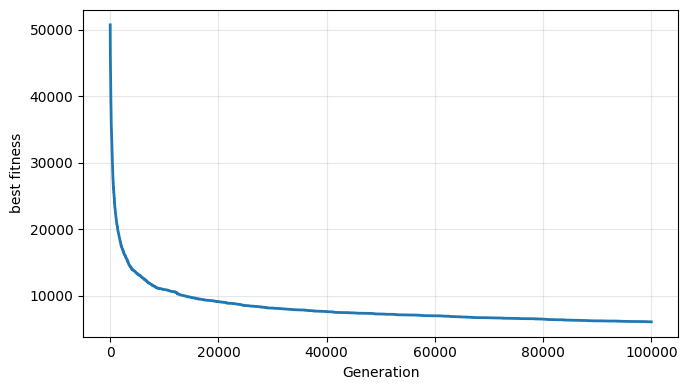

In [41]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 100000

problem = np.load('lab2/problem_r1_1000.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, cycle_crossover, tournament)
ic(best_fitness, best_genotype)

x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(-387.04689379939583)
    best_genotype: array([9, 7, 2, 1, 4, 8, 6, 3, 5, 0], dtype=int32)


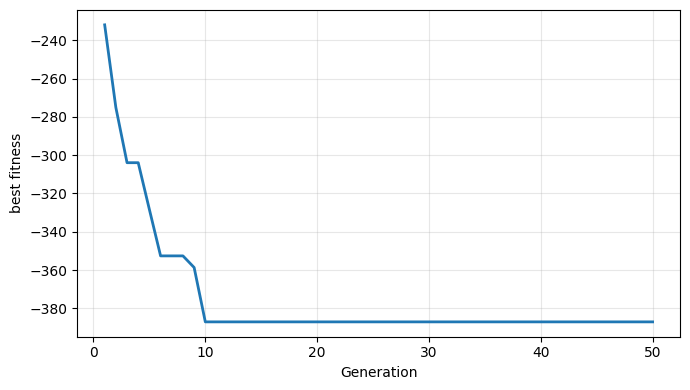

In [42]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 50

problem = np.load('lab2/problem_r2_10.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, pmx, tournament)
ic(best_fitness, best_genotype)

x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(-844.621136585521)
    best_genotype: array([ 9, 15, 19,  2,  6, 16,  8,  0,  4,  1, 11, 17, 13,  7, 18,  3,  5,
                          10, 14, 12], dtype=int32)


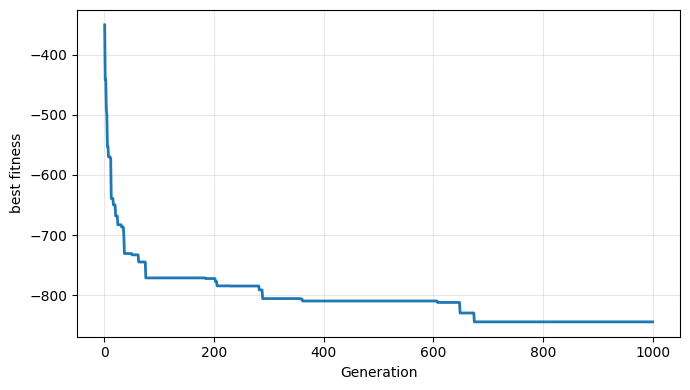

In [43]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 1000

problem = np.load('lab2/problem_r2_20.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, pmx, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(-2221.120988361287)
    best_genotype: array([35, 10, 17, 27, 49, 48, 34,  5, 28, 16, 13, 37, 43, 22, 18, 19, 20,
                          12,  0, 30, 23, 38, 31, 14,  6, 25,  1, 45, 44,  9, 46, 42, 40,  4,
                          39, 36, 15, 26,  3,  8, 33, 47, 32, 21, 24, 41,  7, 11, 29,  2],
                         dtype=int32)


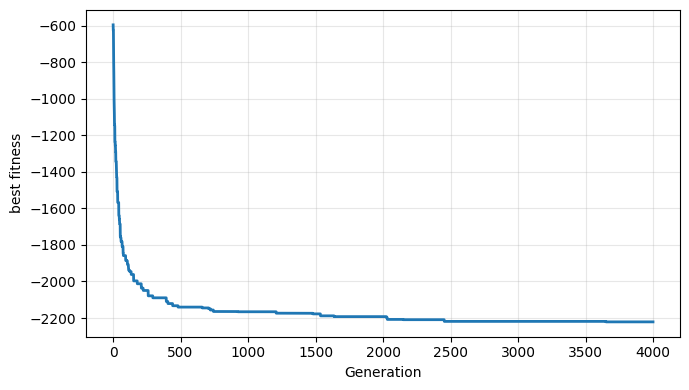

In [44]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 4000

problem = np.load('lab2/problem_r2_50.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, pmx, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(-4632.681510608291)
    best_genotype: array([71, 79, 14, 53, 66, 61, 29, 11, 43, 58, 80, 39, 93, 68, 21,  6, 74,
                          20,  5, 57, 94, 17, 34,  3, 52, 95, 87, 26, 60, 13, 82, 59, 88, 72,
                          31,  2, 42, 83, 45, 86, 77, 90, 62, 81, 98, 19, 84,  4, 69, 46, 44,
                          12, 10, 40, 38, 54, 27, 64, 49, 99,  7, 89, 51, 85, 36, 92, 22, 67,
                          55, 47, 28, 35,  8, 97, 37, 78, 48, 24, 63, 56,  1,  0, 70, 91,  9,
                          41, 50, 96, 76, 73, 23, 16, 15, 65, 32, 25, 33, 18, 30, 75],
                         dtype=int32)


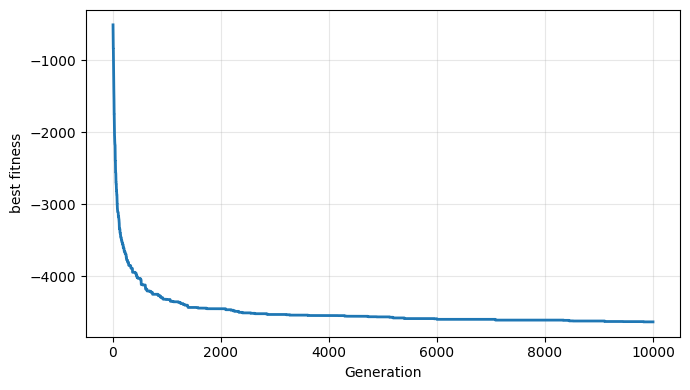

In [45]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 10000

problem = np.load('lab2/problem_r2_100.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, pmx, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(-9349.5112273982)
    best_genotype: array([ 33, 111,  11, 132, 196, 155, 107,  82, 102, 158,  89,  44,  22,
                           39,  70, 131, 134,  43, 170,  61,  18, 154, 150,  68, 190, 128,
                          122, 121,   1, 165,  32, 109,  30,  95,  91,  97,  56,  10,  73,
                          194,  96, 100, 133, 125, 172,   2, 113, 139, 145, 176,  71, 199,
                          126, 156,  88, 146,  55,  13, 168, 184, 153, 105,  93, 116, 182,
                           99,   6,   0, 118,  47,  34, 129, 112, 136, 192, 181, 135,  50,
                          119,  14, 147, 171,  65,  26,   9,  79,  35, 140,  83, 106, 174,
                          138,  81,  92, 162,  37, 151,  31,  45,  94, 191,  84,  12,  80,
                          161,   4,  16,  49, 185,  85,  64, 110,  69, 177, 115,  21, 152,
                          163,  54,  67, 189, 178, 173, 144,  59,  86,  63,  40,  20,   5,
                           25, 167,  52, 15

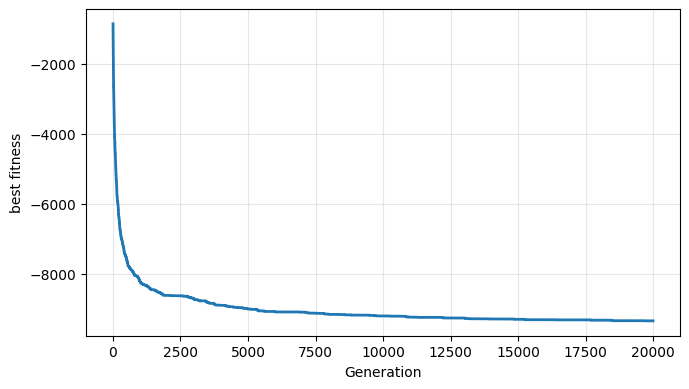

In [46]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 20000

problem = np.load('lab2/problem_r2_200.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, pmx, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(-23397.09774981869)
    best_genotype: array([329, 153, 383, 490, 387,  31, 181, 391, 177, 484, 216, 409, 124,
                          209, 192, 446, 479,  83, 420, 100, 116, 449, 452, 196, 434, 197,
                          382,  43, 199, 311,  36, 163, 341, 140, 139, 326, 472, 396,  65,
                          246,  69, 210, 260, 184, 354, 233, 166, 495, 269, 194, 481, 359,
                          498, 469, 152,  28, 107, 154, 237, 134, 236, 423, 272, 358,  29,
                          251, 258, 474, 295, 172, 418, 344, 275, 338, 259, 339, 465, 182,
                           54,   7,  56, 160, 480, 188, 340, 261, 462,  40, 127, 226, 439,
                           21, 298, 438,  19, 343,  48, 293, 208, 204, 122, 128, 488, 328,
                           11, 310, 457, 370, 489, 454, 366, 331, 256, 393, 335, 415, 288,
                          499, 191, 215,  61, 424, 235, 205, 337, 380, 147, 372, 444, 458,
                          271, 143, 179, 

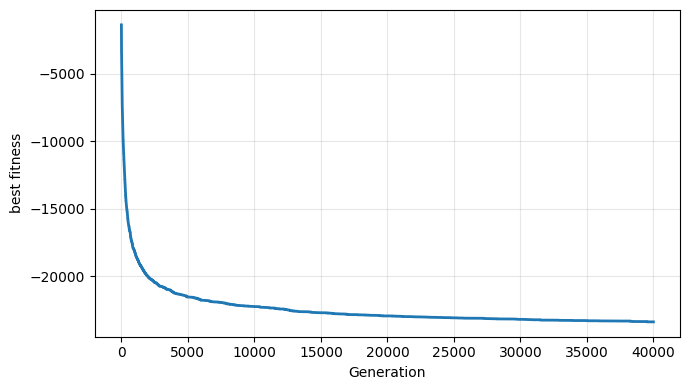

In [47]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 40000

problem = np.load('lab2/problem_r2_500.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, pmx, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ic| best_fitness: np.float64(-46824.367835829835)
    best_genotype: array([769, 237,  27, 176, 806, 150, 617, 164, 670, 651, 895, 579,  34,
                          422,  17, 468, 293, 351, 283, 501, 280, 922, 389,  70, 577, 826,
                          948, 571, 910, 125, 141, 118, 960, 794, 486, 956, 479, 612, 700,
                           87, 782, 732, 278, 598, 249, 739, 225, 195, 404, 886, 289, 894,
                          555, 496, 710, 136, 575, 860, 514, 361, 104, 849, 204, 737, 147,
                          418,  74, 276, 113, 606, 759, 898, 763, 415, 158, 373, 362, 786,
                          325, 880,  10, 946, 228, 741, 761, 466,  93, 526, 821, 359, 138,
                          846, 638, 535,  40, 586, 205, 512, 841, 809, 798, 406, 458, 921,
                           48, 423, 213, 331, 658, 392, 717, 599, 306, 777, 315, 900, 581,
                          235, 300, 597, 111, 976,  32, 284, 187,  25, 116, 661, 932, 295,
                           52,  78, 253,

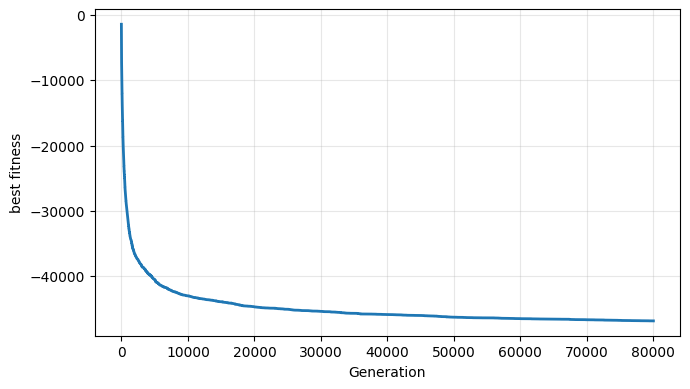

In [48]:
POPULATION_SIZE = 25
OFFSPRING_SIZE = 25
MUTATION_RATE = 0.5
MAX_GENERATIONS = 80000

problem = np.load('lab2/problem_r2_1000.npy')
best_genotype, best_fitness, best_history = tsp_solver(problem, three_opt, pmx, tournament)
ic(best_fitness, best_genotype)
x = np.arange(1, len(best_history) + 1)
plt.figure(figsize=(7, 4))
plt.plot(x, best_history, color='tab:blue', lw=2)
plt.xlabel('Generation')
plt.ylabel('best fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()